## BT
#### Modules

In [1]:
import time
import os
import math
import pickle
import pandas as pd
import numpy as np
import numpy
import datetime as dt
import seaborn as sns
import scipy
import scipy.stats as sts
import matplotlib.pyplot as plt
import matplotlib.dates as pltdt
from keras import regularizers
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Flatten, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
import keras.backend as K
from keras.models import load_model
from keras.utils import plot_model
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error
from IPython.display import HTML, Image
# %matplotlib inline

sns.set_style("darkgrid")
seed = 314159
np.random.seed(seed)

Using TensorFlow backend.


### Load and preview dataset

In [2]:
# Source https://www.quandl.com/data/BITFINEX/BTCUSD-BTC-USD-Exchange-Rate
database = pd.read_csv("btc.csv",skipinitialspace=True)
print("First 3 rows")
display(database.head(3))
print("Last 3 rows")
display(database.tail(3))
print('Dataset preview')
print('Initial dataset size=',database.shape)

First 3 rows


,Date,High,Low,Mid,Last,Bid,Ask,Volume
0,2018-06-29,6302.0,5780.0,6230.55,6230.500000,6230.5,6230.6,34457.733015
1,2018-06-28,6192.7,5886.0,5921.75,5921.785518,5921.7,5921.8,16187.471609
2,2018-06-27,6173.5,5984.9,6139.55,6139.500000,6139.5,6139.6,19383.826482


Last 3 rows


,Date,High,Low,Mid,Last,Bid,Ask,Volume
1502,2014-04-17,538.5,486.1,507.020,508.0,506.04,508.00,20709.783819
1503,2014-04-16,547.0,495.0,537.500,538.0,537.00,538.00,29633.358705
1504,2014-04-15,513.9,452.0,504.235,505.0,503.50,504.97,21013.584774


Dataset preview
Initial dataset size= (1505, 8)


#### Legend
High - Highest daily price [\$]<br>
Low - Lowest daily price [\$] <br>
Mid - Mean daily price [\$] <br>
Last - Closing price of the day [\$] <br>
Bid - Last bid price of the day [\$] <br>
Ask - Last ask price of the day [\$] <br>
Volume - Total number of btc traded[BTC] <br>

### Dataset preparation
#### Ignore missing values

In [3]:
database.replace(9999.9, np.nan,inplace=True)
database.replace(999.9, np.nan,inplace=True)
database.dropna(inplace=True)
print('Final dataset size=',database.shape)

Final dataset size= (1505, 8)


#### Set datetime type index

In [4]:
database["timestamp"]=pd.to_datetime(database["Date"], format='%Y%m%d', errors='ignore')
database.drop(["Date",],axis=1,inplace=True)
database.set_index("timestamp", inplace = True)
display(database.head())

,High,Low,Mid,Last,Bid,Ask,Volume
timestamp,,,,,,,
2018-06-29,6302.0,5780.0,6230.55,6230.500000,6230.5,6230.6,34457.733015
2018-06-28,6192.7,5886.0,5921.75,5921.785518,5921.7,5921.8,16187.471609
2018-06-27,6173.5,5984.9,6139.55,6139.500000,6139.5,6139.6,19383.826482
2018-06-26,6280.8,6100.5,6158.70,6159.700000,6158.6,6158.8,16692.391396
2018-06-25,6341.0,6068.5,6240.05,6240.000000,6240.0,6240.1,28115.802565


In [5]:
database.sort_values(by=('timestamp'),ascending=True, inplace=True)
database.head()
database.index=pd.to_datetime(database.index)

#### Correlation Matrix

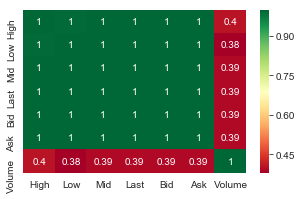

In [30]:
plt.subplots(figsize=(5, 3))
sns.heatmap(database.corr(), annot=True, cmap="RdYlGn");

### Exploratory plots

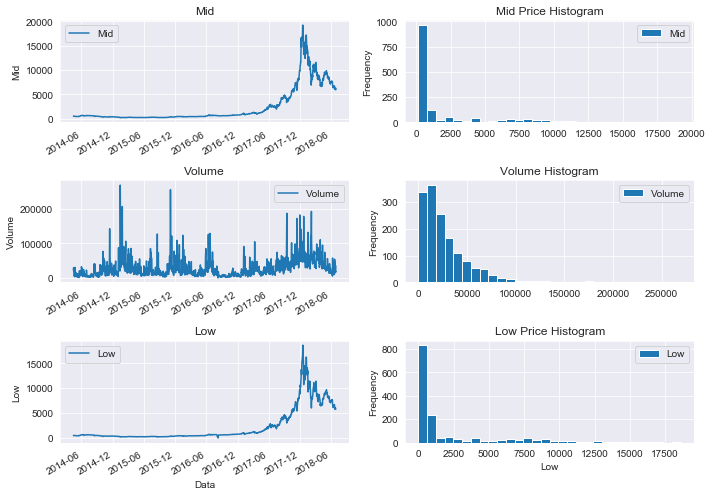

In [36]:
fig, axes = plt.subplots(nrows=3, ncols=2,figsize=(10, 7))
ax=database.plot(y='Mid', ax=axes[0,0],title='Mid')
ax.set_xlabel("")
ax.set_ylabel("Mid")
plt.tight_layout()
ax=database.plot.hist(y='Mid',bins=30,ax=axes[0,1],title='Mid Price Histogram')
ax.set_xlabel("")
ax.set_ylabel("Frequency")
plt.tight_layout()
ax=database.plot(y='Volume',ax=axes[1,0],title='Volume')
ax.set_xlabel("")
ax.set_ylabel("Volume")
plt.tight_layout()
ax=database.plot.hist(y='Volume',bins=30,ax=axes[1,1],title='Volume Histogram')
ax.set_xlabel("")
ax.set_ylabel("Frequency")
plt.tight_layout()
ax=database.plot(y='Low',ax=axes[2,0],title='Low')
ax.set_xlabel("Data")
ax.set_ylabel("Low")
plt.tight_layout()
ax=database.plot.hist(y='Low',bins=30,ax=axes[2,1],title='Low Price Histogram')
ax.set_xlabel("Low")
ax.set_ylabel("Frequency");

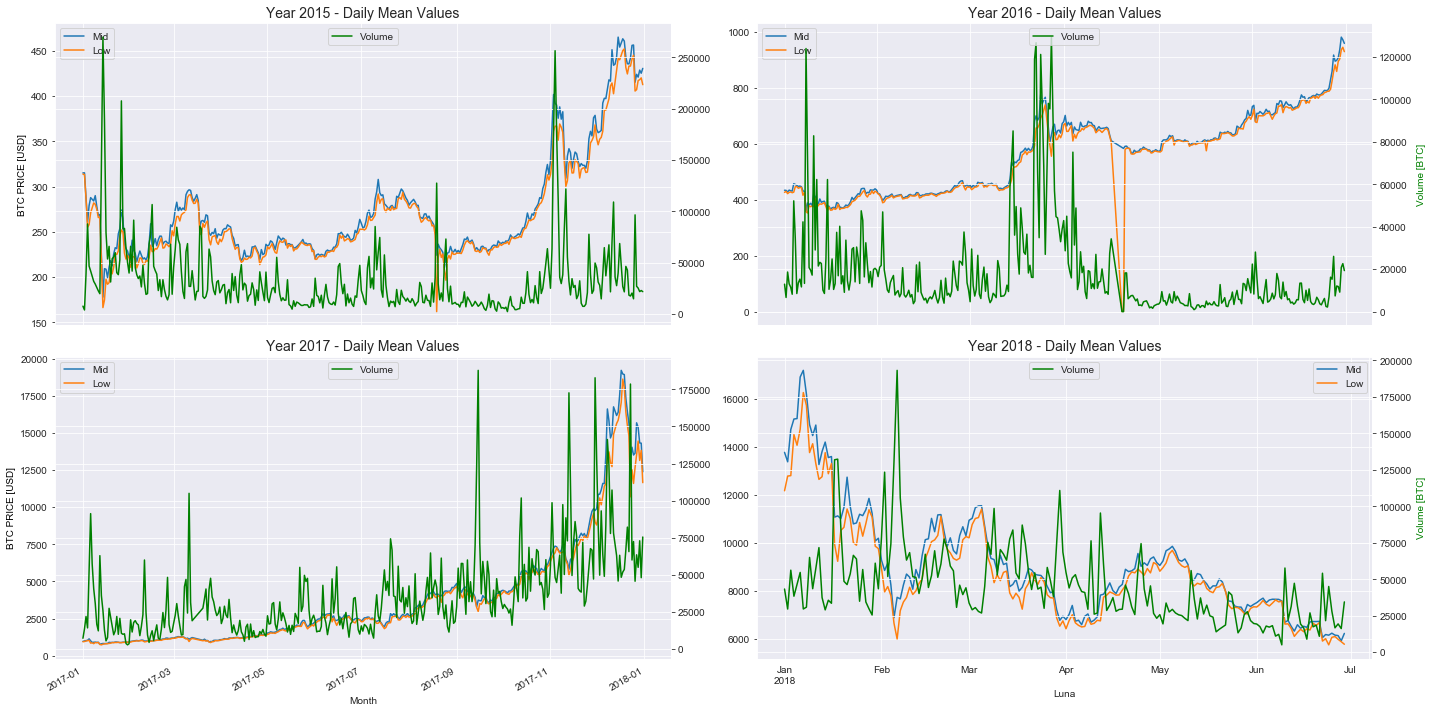

In [32]:
fig = plt.figure(figsize = (20,10))
ax1 = fig.add_subplot(221)
year= '2015'
database[year]['Mid'].plot(fontsize = 10, legend=True,ax=ax1)
database[year]['Low'].plot(fontsize = 10,legend=True, ax=ax1)
ax1.set_title("Year "+year+" - Daily Mean Values",fontsize= 14)
ax1.set_xlabel("Month",fontsize= 10)
ax1.set_ylabel("BTC PRICE [USD]",fontsize= 10,color='k')
ax1.legend(loc='best')
# plt.tight_layout()
ax_s=ax1.twinx()
database[year]['Volume'].plot(fontsize = 10,color='g',ax=ax_s)
ax_s.legend(loc='upper center')
plt.tight_layout()

ax2 = fig.add_subplot(222)#, sharex=ax1, sharey=ax1)
year= '2016'
database[year]['Mid'].plot(fontsize = 10, legend=True,ax=ax2)
database[year]['Low'].plot(fontsize = 10,legend=True, ax=ax2)
ax2.set_title("Year "+year+" - Daily Mean Values",fontsize= 14)
ax2.set_xlabel("Luna",fontsize= 10)
ax2.legend(loc='best')
# plt.tight_layout()
ax_s=ax2.twinx()
database[year]['Volume'].plot(fontsize = 10,color='g',ax=ax_s)
ax_s.legend(loc='upper center')
ax_s.set_ylabel("Volume [BTC]",fontsize= 10,color='g')
plt.tight_layout()

ax3 = fig.add_subplot(223)
year= '2017'
database[year]['Mid'].plot(fontsize = 10, legend=True,ax=ax3)
database[year]['Low'].plot(fontsize = 10,legend=True, ax=ax3)
ax3.set_title("Year "+year+" - Daily Mean Values",fontsize= 14)
ax3.set_xlabel("Month",fontsize= 10)
ax3.set_ylabel("BTC PRICE [USD]",fontsize= 10,color='k')
ax3.legend(loc='best')
# plt.tight_layout()
ax_s=ax3.twinx()
database[year]['Volume'].plot(fontsize = 10,color='g',ax=ax_s)
ax_s.legend(loc='upper center')
plt.tight_layout()

ax4 = fig.add_subplot(224)
year= '2018'
database[year]['Mid'].plot(fontsize = 10, legend=True,ax=ax4)
database[year]['Low'].plot(fontsize = 10,legend=True, ax=ax4)
ax4.set_title("Year "+year+" - Daily Mean Values",fontsize= 14)
ax4.set_xlabel("Luna",fontsize= 10)
ax4.legend(loc='best')
# plt.tight_layout()
ax_s=ax4.twinx()
database[year]['Volume'].plot(fontsize = 10,color='g',ax=ax_s)
ax_s.legend(loc='upper center')
ax_s.set_ylabel("Volume [BTC]",fontsize= 10,color='g')
plt.tight_layout()

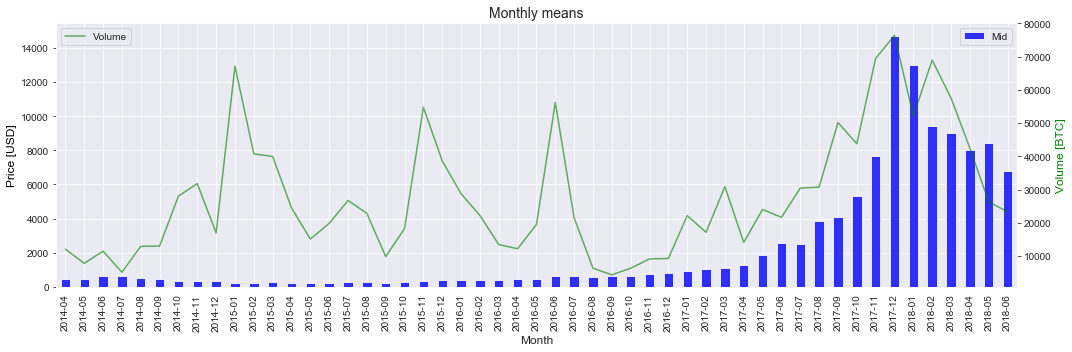

In [33]:
coun=database
coun['Month']=coun.index.map(lambda x: x.strftime('%Y-%m'))
coun['Month_only']=coun.index.map(lambda x: x.strftime('%m'))
c_group_month = coun.groupby('Month').mean()

fig, ax = plt.subplots(figsize=(15,5))
c_group_month['Mid'].plot(fontsize =10, legend=True, kind='bar', color='blue', ax=ax, alpha=0.8)
# ax.set_xticklabels(c_group_month['Mid'])
ax.set_title("Monthly means",fontsize=14)
ax.set_xlabel("Month",fontsize=12)
ax.set_ylabel("Price [USD]",fontsize=12,color='k')
ax_s = ax.twinx()
c_group_month['Volume'].plot(fontsize =10,color='g',alpha=0.6, ax=ax_s, grid=0)
ax_s.legend(loc='upper left')
ax_s.set_ylabel("Volume [BTC]",fontsize=12,color='g')
plt.tight_layout()

Text(0,0.5,'Volume [BTC]')

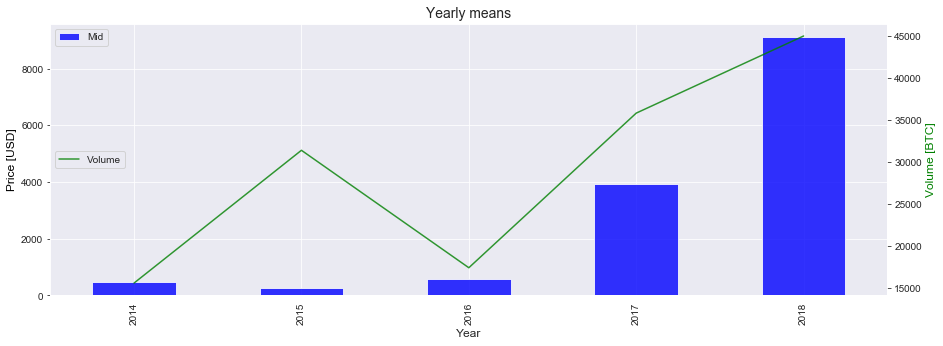

In [34]:
coun['Year']=coun.index.map(lambda x: x.strftime('%Y'))
c_group_year = coun.groupby('Year').mean()

fig, ax = plt.subplots(figsize=(15,5))
c_group_year['Mid'].plot(fontsize =10, legend=True, kind='bar', color='blue', ax=ax, alpha=0.8)
ax.set_title("Yearly means",fontsize=14)
ax.set_xlabel("Year",fontsize=12)
ax.set_ylabel("Price [USD]",fontsize=12,color='k')
ax2 = ax.twinx()
ax2=c_group_year['Volume'].plot(fontsize =10,color='g',alpha=0.8, grid=0, ax=ax2)
ax2.legend(loc='center left')
ax2.set_ylabel("Volume [BTC]",fontsize=12,color='g')

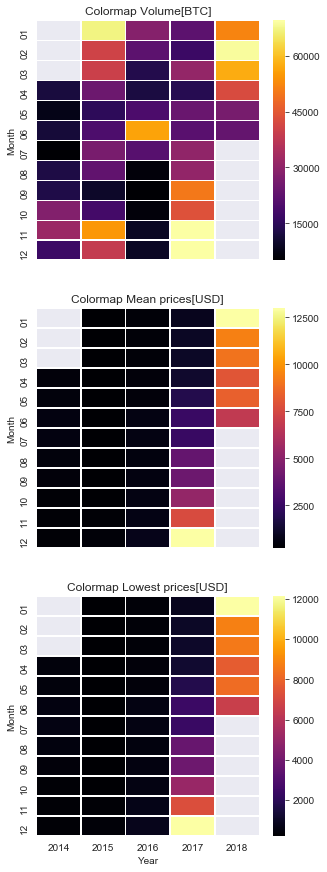

In [35]:
fig = plt.figure(figsize=(5, 15))
ax=plt.subplot(3, 1, 1)
pt_heatmap = coun.loc[coun["Year"] >= str(1973)].pivot_table(index = 'Month_only',
                                        columns = 'Year', values = 'Volume')
pt_heatmap.sort_index(level = 0, ascending = True, inplace = True)
sns.heatmap(pt_heatmap, cmap = 'inferno', linewidth = 0.5,robust =1,ax=ax)
ax.set_title("Colormap Volume[BTC]",fontsize=12)
ax.set_xlabel("")
ax.set_xticks([])
ax.set_ylabel("Month", fontsize=10)


ax=plt.subplot(3, 1, 2)
pt_heatmap = coun.loc[coun["Year"] >= str(1973)].pivot_table(index = 'Month_only', 
                                                columns = 'Year', values = 'Mid')
pt_heatmap.sort_index(level = 0, ascending = True, inplace = True)
ax=sns.heatmap(pt_heatmap, cmap = 'inferno', linewidth = 0.5,robust =1,ax=ax)
ax.set_title("Colormap Mean prices[USD]",fontsize=12)
ax.set_xlabel("")
ax.set_xticks([])
ax.set_ylabel("Month", fontsize=10)

ax=plt.subplot(3, 1, 3)
pt_heatmap = coun.loc[coun["Year"] >= str(1973)].pivot_table(index = 'Month_only', 
                                        columns = 'Year', values = 'Low')
pt_heatmap.sort_index(level = 0, ascending = True, inplace = True)
ax=sns.heatmap(pt_heatmap, cmap = 'inferno', linewidth = 0.5,robust =1,ax=ax)
ax.set_title("Colormap Lowest prices[USD]",fontsize=12)
ax.set_ylabel("Month", fontsize=10);

### Prepare train and test sets

### A. LSTM Neural network - single input
#### Only mid prices will be feeded in as input

In [6]:
numpy.random.seed(7)
K.clear_session()

def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

df= database['Mid']
df=df.reset_index()
df.drop(columns=['timestamp'], inplace=True)
dataframe = df
dataset = dataframe.values
dataset = dataset.astype('float32')
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train = dataset
look_back = 45
n_epochs = 1000
dropout=.05

trainX, trainY = create_dataset(train, look_back)
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))

In [7]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(36,return_sequences = True,input_shape=(1, look_back), dropout=dropout))
model.add(LSTM(18, return_sequences = True, dropout=dropout))
model.add(LSTM(9, return_sequences = False, dropout=dropout))
# model.add(Dense(9, activation='linear',kernel_regularizer=regularizers.l2(0.01), activity_regularizer=regularizers.l1(0.01)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
#Callbacks
earlystop_crit = EarlyStopping(monitor='loss', min_delta=0, patience=150, verbose=1, mode='min')
filepath="nn_weights-{epoch:02d}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=0, 
                                             save_weights_only=False, save_best_only=False, mode='min')
start_time = time.time()
history = model.fit(trainX, trainY, epochs=n_epochs, batch_size=50, verbose=2, callbacks=[earlystop_crit,checkpoint])
time_s = time.time() - start_time
print("Necessary training time %0.1f sec / %0.1f min / %0.1f h" % (time_s,time_s/60,time_s/60/60))

Epoch 1/1000
 - 14s - loss: 0.0378
Epoch 2/1000
 - 1s - loss: 0.0113
Epoch 3/1000
 - 1s - loss: 0.0042
Epoch 4/1000
 - 1s - loss: 0.0032
Epoch 5/1000
 - 1s - loss: 0.0028
Epoch 6/1000
 - 1s - loss: 0.0025
Epoch 7/1000
 - 1s - loss: 0.0021
Epoch 8/1000
 - 1s - loss: 0.0016
Epoch 9/1000
 - 1s - loss: 0.0014
Epoch 10/1000
 - 1s - loss: 0.0013
Epoch 11/1000
 - 1s - loss: 0.0012
Epoch 12/1000
 - 1s - loss: 0.0012
Epoch 13/1000
 - 1s - loss: 0.0011
Epoch 14/1000
 - 2s - loss: 0.0012
Epoch 15/1000
 - 1s - loss: 0.0012
Epoch 16/1000
 - 1s - loss: 0.0011
Epoch 17/1000
 - 4s - loss: 0.0010
Epoch 18/1000
 - 1s - loss: 0.0011
Epoch 19/1000
 - 1s - loss: 9.6022e-04
Epoch 20/1000
 - 2s - loss: 0.0011
Epoch 21/1000
 - 2s - loss: 9.8461e-04
Epoch 22/1000
 - 2s - loss: 9.8483e-04
Epoch 23/1000
 - 1s - loss: 0.0010
Epoch 24/1000
 - 2s - loss: 0.0011
Epoch 25/1000
 - 2s - loss: 8.2933e-04
Epoch 26/1000
 - 1s - loss: 8.2716e-04
Epoch 27/1000
 - 1s - loss: 8.6539e-04
Epoch 28/1000
 - 1s - loss: 9.2376e-04


Score train: 248.12 RMSE


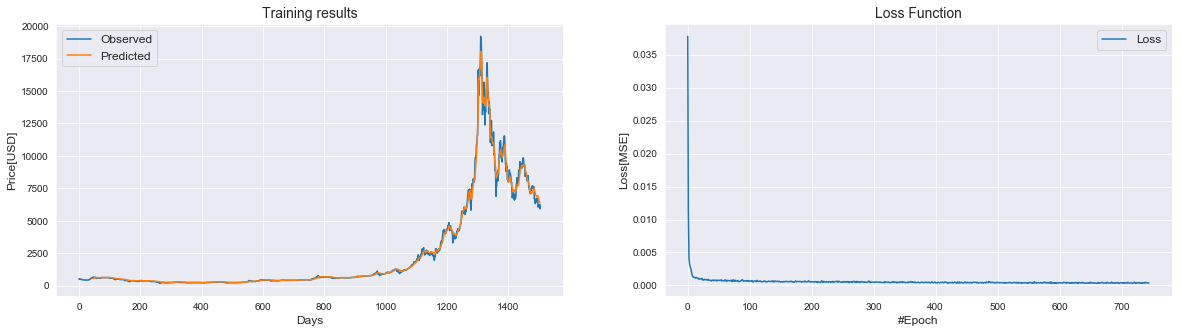

In [14]:
trainPredict = model.predict(trainX)
trainPredict = scaler.inverse_transform(trainPredict)
trainY_i = scaler.inverse_transform([trainY])
trainScore = math.sqrt(mean_squared_error(trainY_i[0], trainPredict[:,0]))
print('Score train: %.2f RMSE' % (trainScore))
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# plot baseline and predictions
fig = plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(scaler.inverse_transform(dataset),label='Observed')
plt.plot(trainPredictPlot,label='Predicted')
plt.title('Training results',fontsize=14)
plt.xlabel('Days',fontsize=12)
plt.ylabel('Price[USD]',fontsize=12)
plt.legend(fontsize=12)
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Loss')
plt.grid()
plt.xlabel('#Epoch',fontsize=12)
plt.ylabel('Loss[MSE]',fontsize=12)
plt.title('Loss Function',fontsize=14)
plt.grid()
plt.legend(fontsize=12);

#### Save current model

In [ ]:
# model_num = 3
# nn_filename= os.path.abspath(os.path.join(os.path.dirname("__file__"), ('nn_saved/M_'+str(model_num)+'nn_initial.h5')))
# hist_filename = os.path.abspath(os.path.join(os.path.dirname("__file__"),('nn_saved/M_'+str(model_num)+'nn_initial.pickle')))
# model.save(nn_filename)  # creates a HDF5 file
# with open(hist_filename, 'wb') as handle:
#     pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)
# # del model

#### Load saved model

In [ ]:
# model_num = 2
# nn_filename= os.path.abspath(os.path.join(os.path.dirname("__file__"), ('nn_saved/M_'+str(model_num)+'nn_initial.h5')))
# hist_filename = os.path.abspath(os.path.join(os.path.dirname("__file__"),('nn_saved/M_'+str(model_num)+'nn_initial.pickle')))
# model = load_model(nn_filename)
# with open(hist_filename, 'rb') as handle:
#     history = pickle.load(handle)

In [ ]:
# plot_model(model, to_file='keras_plot_model.png', show_shapes=True)
# display(Image(filename='keras_plot_model.png', width=250))

In [10]:
def moving_test_window_preds(n_future_preds):

    ''' n_future_preds - Represents the number of future predictions we want to make
                         This coincides with the number of windows that we will move forward
                         on the test data
    '''
    preds_moving = []                                       
    moving_test_window= trainX[-1,].reshape(1,1,look_back)
    
    for i in range(n_future_preds):
        preds_one_step = model.predict(moving_test_window) 
        preds_moving.append(preds_one_step[0,0]) 
        preds_one_step = preds_one_step.reshape(1,1,1) 
        moving_test_window = np.concatenate((moving_test_window, preds_one_step), axis=2)
        moving_test_window = moving_test_window[:,:,1:]
    
    return preds_moving

In [ ]:
n_future_preds = 300
n_initial_obs = 0
n_available = trainX.shape[0] + look_back+1
n_final_obs = n_available + n_future_preds

range_train = numpy.arange(n_initial_obs, n_available, 1)
range_test = numpy.arange(n_available ,n_final_obs, 1)
range_final = numpy.arange(n_initial_obs, n_final_obs, 1)

In [19]:
database2 = pd.read_csv("BITFINEX-BTCUSD.csv",skipinitialspace=True)
database2["timestamp"]=pd.to_datetime(database2["Date"], format='%Y%m%d', errors='ignore')
database2.drop(["Date",],axis=1,inplace=True)
database2.set_index("timestamp", inplace = True)
display(database2.head())
database2.sort_values(by=('timestamp'),ascending=True, inplace=True)
database2.head()
database2.index=pd.to_datetime(database2.index)

,High,Low,Mid,Last,Bid,Ask,Volume
timestamp,,,,,,,
2018-07-17,7483.9,6666.0,7290.85,7288.30898,7290.8,7290.9,48584.139147
2018-07-16,6711.0,6327.1,6665.55,6665.60000,6665.5,6665.6,29278.425863
2018-07-15,6389.0,6230.3,6360.60,6360.50000,6360.4,6360.8,10771.480408
2018-07-14,6320.0,6179.2,6259.35,6259.30000,6259.3,6259.4,9178.169034
2018-07-13,6339.9,6079.9,6205.35,6205.30000,6205.3,6205.4,23490.246614


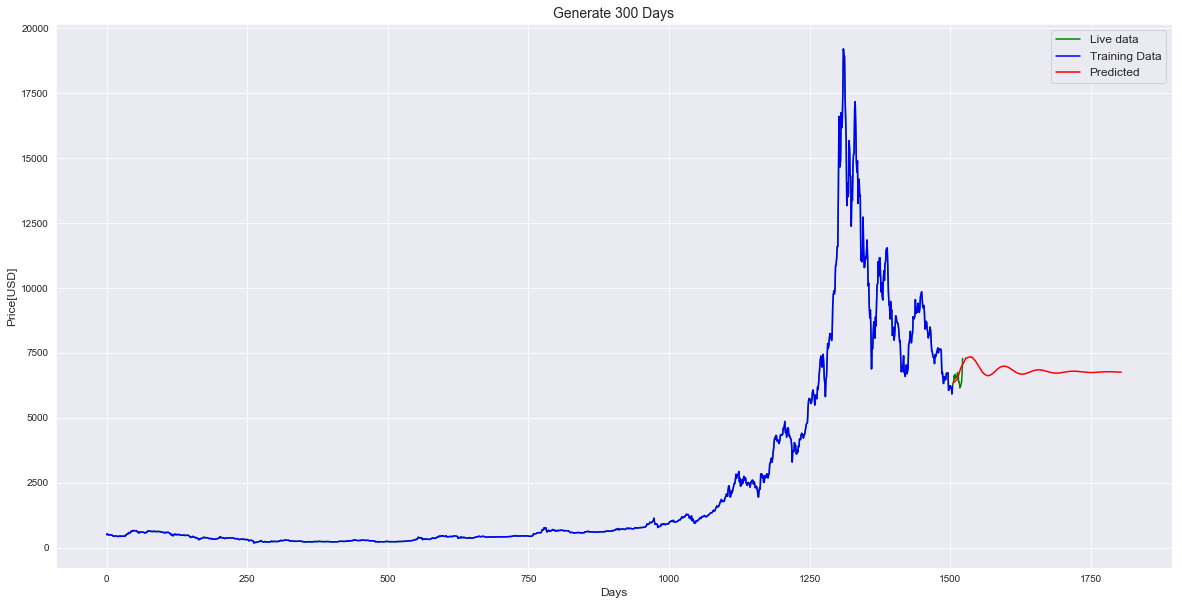

In [24]:
fig= plt.figure(figsize=(20,10))
preds_moving=moving_test_window_preds(n_future_preds)
dataset_train_u = np.array([i[0] for i in dataset])
pred_train_uni = scaler.inverse_transform(dataset_train_u.reshape(-1, 1))
dataset_test_uni = np.array(preds_moving)
pred_test_uni = scaler.inverse_transform(dataset_test_uni.reshape(-1, 1))
plt.plot(np.arange(0,len(database2['Mid']),1),database2['Mid'],label='Live data', color='green')
plt.plot(range_train, pred_train_uni, color='b',label='Training Data')
plt.plot(range_test, pred_test_uni, color='r', label='Predicted')
plt.title('Generate '+str(n_future_preds)+' Days',fontsize=14)
plt.xlabel('Days',fontsize=12)
# plt.xticks(numpy.arange(n_initial_obs, n_final, 4))
plt.ylabel('Price[USD]',fontsize=12)
plt.legend(fontsize=12);

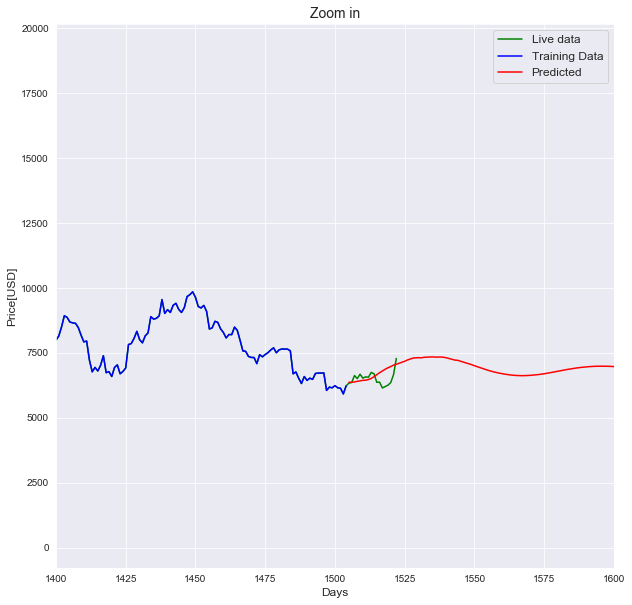

In [29]:
fig= plt.figure(figsize=(10,10))
plt.plot(np.arange(0,len(database2['Mid']),1),database2['Mid'],label='Live data', color='green')
plt.plot(range_train, pred_train_uni, color='b',label='Training Data')
plt.plot(range_test, pred_test_uni, color='r', label='Predicted')
plt.title('Zoom in',fontsize=14)
plt.xlabel('Days',fontsize=12)
# plt.xticks(numpy.arange(n_initial_obs, n_final, 4))
plt.ylabel('Price[USD]',fontsize=12)
plt.xlim(1400,1600)
plt.legend(fontsize=12);

In [ ]:
set_initial_uni = set_initial
set_predictie_uni = set_predictie
set_final_uni = set_final

### B. LSTM Neural network - multi-input - Not finished
#### High, Low, Volume

In [ ]:
K.clear_session()
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)
df=coun.groupby('Year').max()
df=df.reset_index()
df=df.drop(columns=['Year','Month','Month_only'], inplace=False)
dataframe = df
dataset = dataframe.values
dataset = dataset.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_temp = dataset[:,0].reshape(len(dataset[:,0]),1)
train_wdsp = dataset[:,1].reshape(len(dataset[:,1]),1)
train_mxspd = dataset[:,2].reshape(len(dataset[:,2]),1)
look_back = 5
n_epochs = 1444
dropout=.05

trainX_temp, trainY_temp = create_dataset(train_temp, look_back)
trainX_temp = numpy.reshape(trainX_temp, (trainX_temp.shape[0], 1, trainX_temp.shape[1]))
trainY_temp = trainY_temp.reshape(len(trainY_temp),1)

trainX_wdsp, trainY_wdsp = create_dataset(train_wdsp, look_back)
trainX_wdsp = numpy.reshape(trainX_wdsp, (trainX_wdsp.shape[0], 1, trainX_wdsp.shape[1]))
trainY_wdsp = trainY_wdsp.reshape(len(trainY_wdsp),1)

trainX_mxspd, trainY_mxspd = create_dataset(train_mxspd, look_back)
trainX_mxspd = numpy.reshape(trainX_mxspd, (trainX_mxspd.shape[0], 1, trainX_mxspd.shape[1]))
trainY_mxspd = trainY_mxspd.reshape(len(trainY_mxspd),1)

trainX = np.concatenate((trainX_temp,trainX_wdsp,trainX_mxspd),axis=1)
trainY = np.concatenate((trainY_temp,trainY_wdsp,trainY_mxspd),axis=1)

In [ ]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(36,return_sequences = True,input_shape=(3, look_back), dropout=dropout))
model.add(LSTM(18, return_sequences = True, dropout=dropout))
model.add(LSTM(9, return_sequences = False, dropout=dropout))
# model.add(Dense(9, activation='linear',kernel_regularizer=regularizers.l2(0.01), activity_regularizer=regularizers.l1(0.01)))
model.add(Dense(3))
model.compile(loss='mean_squared_error', optimizer='adam')
start_time = time.time()
history = model.fit(trainX, trainY, epochs=n_epochs, batch_size=1, verbose=2)
time_s = time.time() - start_time
print("Timp de antrenare %0.1f secunde / %0.1f minute / %0.1f ore" % (time_s,time_s/60,time_s/60/60))

In [ ]:
trainPredict = model.predict(trainX)
trainPredict = scaler.inverse_transform(trainPredict)
trainY_i = scaler.inverse_transform(trainY)
trainScore = math.sqrt(mean_squared_error(trainY_i, trainPredict))
print('Scor: %.2f RMSE' % (trainScore))
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

dataset_i = scaler.inverse_transform(dataset)
# plot baseline and predictions
fig = plt.figure(figsize=(12,10))
plt.subplot(2,2,1)
plt.plot(dataset_i[:,0],label='Observed')
plt.plot(trainPredictPlot[:,0],label='Predicted')
plt.title('Rezultate - TEMP',fontsize=14)
plt.xlabel('Ani',fontsize=12)
plt.ylabel('Temperatura [$^\circ$C]',fontsize=12)
plt.legend(fontsize=12)

plt.subplot(2,2,2)
plt.plot(dataset_i[:,1],label='Observed')
plt.plot(trainPredictPlot[:,1],label='Predicted')
plt.title('Rezultate - WDSP',fontsize=14)
plt.xlabel('Ani',fontsize=12)
plt.ylabel('Viteza vant de referinta[m/s]',fontsize=12)
plt.legend(fontsize=12)

plt.subplot(2,2,3)
plt.plot(dataset_i[:,2],label='Observed')
plt.plot(trainPredictPlot[:,2],label='Predicted')
plt.title('Rezultate - MXSPD',fontsize=14)
plt.xlabel('Ani',fontsize=12)
plt.ylabel('Viteza vant de referinta[m/s]',fontsize=12)
plt.legend(fontsize=12)

plt.subplot(2,2,4)
plt.plot(history['loss'], label='Loss')
plt.grid()
plt.xlabel('#Epoch',fontsize=12)
plt.ylabel('Loss[MSE]',fontsize=12)
plt.title('Evolutia functiei de loss',fontsize=14)
plt.grid()
plt.legend(fontsize=12);

In [ ]:
index_min = np.argmin(history['loss'])+1
print('Precizia ce mai buna se obtine pentru n_epochs=',index_min)

#### Salvare model

In [ ]:
model_num = 2
nn_filename= os.path.abspath(os.path.join(os.path.dirname("__file__"), ('nn_saved/M_'+str(model_num)+'nn_tridimensional.h5')))
hist_filename = os.path.abspath(os.path.join(os.path.dirname("__file__"),('nn_saved/M_'+str(model_num)+'nn_tridimensional.pickle')))
model.save(nn_filename)  # creates a HDF5 file
with open(hist_filename, 'wb') as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)
# del model

#### Incarcare model salvat

In [ ]:
model_num = 1
nn_filename= os.path.abspath(os.path.join(os.path.dirname("__file__"), ('nn_saved/M_'+str(model_num)+'nn_tridimensional.h5')))
hist_filename = os.path.abspath(os.path.join(os.path.dirname("__file__"),('nn_saved/M_'+str(model_num)+'nn_tridimensional.pickle')))
model = load_model(nn_filename)
with open(hist_filename, 'rb') as handle:
    history = pickle.load(handle)

In [ ]:
plot_model(model, to_file='keras_plot_model_tri.png', show_shapes=True)
display(Image(filename='keras_plot_model_tri.png', width=250))

In [ ]:
def moving_test_window_preds_3(n_future_preds):

    ''' n_future_preds - Represents the number of future predictions we want to make
                         This coincides with the number of windows that we will move forward
                         on the test data
    '''
    preds_moving = []                                       
    moving_test_window= trainX[-2:-1,:,:].reshape(1,3,look_back)
    
    for i in range(n_future_preds):
        preds_one_step = model.predict(moving_test_window) 
        preds_moving.append(preds_one_step[0,:]) 
        preds_one_step = preds_one_step.reshape(1,3,1) 
        moving_test_window = np.concatenate((moving_test_window, preds_one_step), axis=2)
        moving_test_window = moving_test_window[:,:,1:]
    
    return preds_moving

In [ ]:
n_future_preds = 11
n_initial_obs = 1973
n_available = 44
n_final_obs = n_initial_obs + n_available
n_final = n_final_obs + n_future_preds
range_train = numpy.arange(n_initial_obs, n_final_obs, 1)
range_test = numpy.arange(range_train[-1:]+1,n_final,1)
range_final = numpy.arange(n_initial_obs, n_final, 1)

preds_moving=moving_test_window_preds_3(n_future_preds)
pred_train_tri = scaler.inverse_transform(dataset)
dataset_test_tri = np.array(preds_moving)
pred_test_tri = scaler.inverse_transform(dataset_test_tri)
te_pl_y = np.concatenate((pred_train_tri, pred_test_tri[0:1,:]), axis=0)
te_pl_x = np.concatenate((range_initial, range_test[0:1]), axis=0)

In [ ]:
fig= plt.figure(figsize=(10,10))

plt.subplot(3,1,1)
plt.plot(te_pl_x, te_pl_y[:,0], color='b', label='Observed')
plt.plot(range_test, pred_test_tri[:,0], color='r',label='Predicted')
plt.title('Generare 10 valori - Retea LSTM tridimensionala\nTEMP',fontsize=14)
plt.xticks(numpy.arange(n_initial_obs, n_final, 4))
plt.tick_params(labelbottom=False)
plt.ylabel('Temperatura [$^\circ$C]',fontsize=12)
plt.legend(fontsize=12)
plt.tight_layout()

plt.subplot(3,1,2)
plt.plot(te_pl_x, te_pl_y[:,1], color='b', label='Observed')
plt.plot(range_test, pred_test_tri[:,1], color='r',label='Predicted')
plt.title('WDSP',fontsize=14)
plt.xticks(numpy.arange(n_initial_obs, n_final, 4))
plt.tick_params(labelbottom=False)
plt.ylabel('Viteza vant de referinta[m/s]',fontsize=12)
plt.legend(fontsize=12)
plt.tight_layout()

plt.subplot(3,1,3)
plt.plot(te_pl_x, te_pl_y[:,2], color='b', label='Observed')
plt.plot(range_test, pred_test_tri[:,2], color='r',label='Predicted')
plt.title('MXSPD',fontsize=14)
plt.xlabel('Ani',fontsize=12)
plt.xticks(numpy.arange(n_initial_obs, n_final, 4))
plt.ylabel('Viteza vant de referinta[m/s]',fontsize=12)
plt.plot(range_test,pred_test_uni,color='C1',alpha=0.5,label='Predicted_uni')
plt.legend(fontsize=12)
plt.tight_layout()

In [ ]:
set_initial = te_pl_y
set_predictie = pred_test_tri[1:]
set_final = np.concatenate((set_initial,set_predictie))
range_initial = te_pl_x
range_final = np.concatenate((te_pl_x,range_test[1:]))
# range_final_fine = np.arange(min(set_final),max(set_final),1)
range_final_fine = np.arange(5,30,1)